In [1]:
from deep_traffic_generation.tc_ae import TCAE
from deep_traffic_generation.core.datasets import TrafficDataset
from deep_traffic_generation.core.utils import traffic_from_data

from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import numpy as np

from traffic.core.projection import EuroPP

import torch

import warnings
warnings.filterwarnings("ignore")

In [2]:
dataset = TrafficDataset(
    "../deep_traffic_generation/data/traffic_15.pkl",
    features=["latitude", "longitude", "altitude", "timedelta"],
    scaler=MinMaxScaler(feature_range=(-1,1)),
    mode="image",
)
dataset

Dataset TrafficDataset
    Number of datapoints: 3968
    File location: ../deep_traffic_generation/data/traffic_15.pkl
    MinMaxScaler(feature_range=(-1, 1))

In [3]:
model = TCAE.load_from_checkpoint(
    "../deep_traffic_generation/lightning_logs/tc_ae/version_0/checkpoints/epoch=307-step=923.ckpt",
    hparams_file="../deep_traffic_generation/lightning_logs/tc_ae/version_0/hparams.yaml",
    x_dim=dataset.input_dim,
    seq_len=dataset.seq_len,
    scaler=dataset.scaler
)
model.eval()

TCAE(
  (encoder): TCEncoder(
    (encoder): Sequential(
      (0): TCN(
        (network): Sequential(
          (0): ResidualBlock(
            (tmp_block1): TemporalBlock(
              (conv): Conv1d(4, 16, kernel_size=(16,), stride=(1,))
              (out_activ): ReLU()
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (tmp_block2): TemporalBlock(
              (conv): Conv1d(16, 16, kernel_size=(16,), stride=(1,))
              (out_activ): ReLU()
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (downsample): Conv1d(4, 16, kernel_size=(1,), stride=(1,))
          )
          (1): ResidualBlock(
            (tmp_block1): TemporalBlock(
              (conv): Conv1d(16, 16, kernel_size=(16,), stride=(1,), dilation=(2,))
              (out_activ): ReLU()
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (tmp_block2): TemporalBlock(
              (conv): Conv1d(16, 16, kernel_size=(16,), str

In [4]:
z = model.encoder(torch.Tensor(dataset.dense))
z.size()

torch.Size([3968, 16])

In [5]:
z_array = z.detach().cpu().numpy()
z_array.shape

(3968, 16)

In [6]:
z_embedded = TSNE(n_components=2).fit_transform(z_array)
z_embedded.shape

(3968, 2)

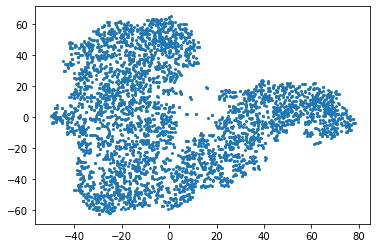

In [7]:
plt.scatter(z_embedded[:, 0], z_embedded[:, 1], s=4)
plt.show()

In [8]:
x, y, info = dataset[0]
x = x.unsqueeze(0)
z, x_hat = model(x)

In [9]:
x.size()

torch.Size([1, 4, 200])

In [10]:
x_hat.size()

torch.Size([1, 4, 200])

In [11]:
z.size()

torch.Size([1, 16])

In [12]:
x = torch.transpose(x, 1, 2)
x_hat = torch.transpose(x_hat, 1, 2)

In [13]:
data = np.concatenate((x.numpy(), x_hat.detach().numpy()))
data = data.reshape((data.shape[0], -1))
data = dataset.scaler.inverse_transform(data)
data.shape

(2, 800)

In [14]:
builder = model.get_builder(data.shape[0])
traffic = traffic_from_data(
    data, model.hparams.features, model.hparams.init_features, builder=builder
)
traffic

,count
flight_id,
0,200
1,200


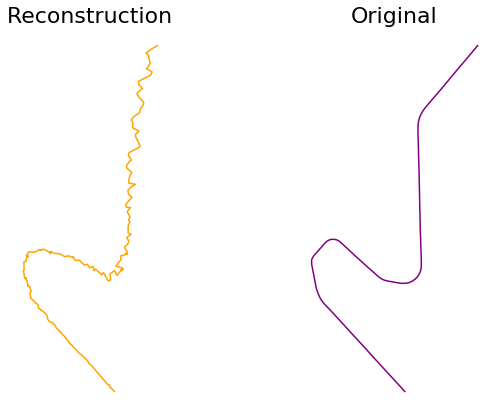

In [15]:
with plt.style.context("traffic"):
    fig, ax = plt.subplots(
        1, 2, subplot_kw=dict(projection=EuroPP()), gridspec_kw={'width_ratios': [1, 1]}
    )
    traffic[1].plot(ax[0], c="orange")
    traffic[0].plot(ax[1], c="purple")
    ax[0].set_title("Reconstruction")
    ax[1].set_title("Original")
    plt.show()